In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions


train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range = 0.3, horizontal_flip = True, preprocessing_function = preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

training_set = train_datagen.flow_from_directory(directory= '/Users/karthiksagar/anaconda3/CropDiseasePrediction/CropDataset/train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = val_datagen.flow_from_directory(directory= '/Users/karthiksagar/anaconda3/CropDiseasePrediction/CropDataset/valid',
                                            target_size = (256, 256), 
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 7880 images belonging to 35 classes.
Found 3451 images belonging to 35 classes.


In [3]:
test_img, label = training_set.next()

In [4]:
test_img.shape

(32, 256, 256, 3)

In [8]:
def plotimg(img_arr, label):
    for img, lab in zip(img_arr, label):
        plt.figure(figsize=(5,5))
        plt.imshow(img/255)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


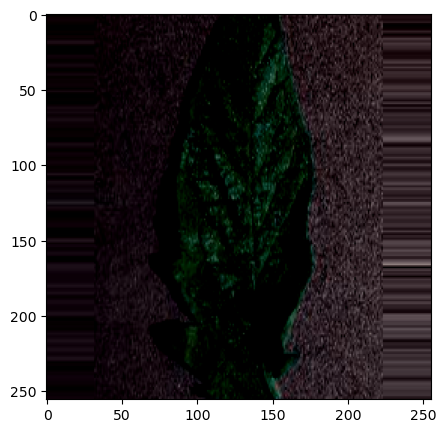

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


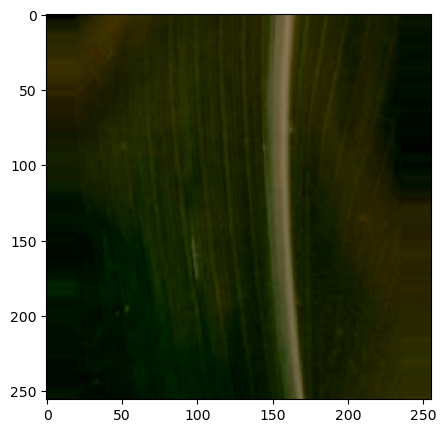

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


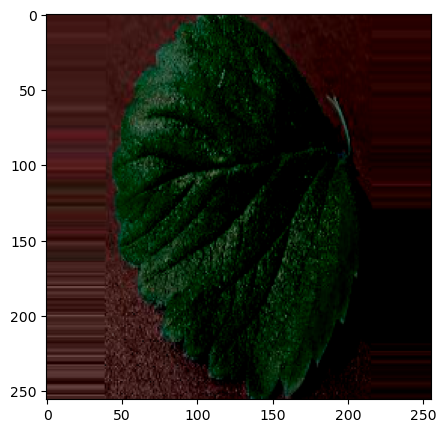

In [9]:
plotimg(test_img[:3], label[:3])

### Creating Model

In [2]:
from keras.layers import Dense, Flatten
from keras.optimizers import SGD, Adam, Adagrad
from keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
import keras

In [3]:
base_model = VGG19(input_shape=(256,256,3), include_top=False)

In [4]:
for layer in base_model.layers:
    layer.trainable = False

In [5]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [6]:
X = Flatten()(base_model.output)

X = Dense(units = 35, activation='softmax')(X)

#final model
model = Model(base_model.input, X)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [18]:
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

### Early Stopping and Model Checkpoint

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Early Stopping
es = EarlyStopping(monitor= 'val_accuracy', min_delta=0.01, patience=3, verbose= 1)

## Model Checkpoint
mc = ModelCheckpoint(filepath="/Users/karthiksagar/anaconda3/CropDiseasePrediction/best_model.h5",  monitor= 'val_accuracy', min_delta=0.01, patience=3, verbose= 1, save_best_only= True)

callback = [es,mc]

In [20]:
history = model.fit_generator(training_set, validation_data= test_set, callbacks= callback, steps_per_epoch=16, verbose=1, epochs=50, validation_steps=16)


/var/folders/vz/r8m2cmcn1vd2j0q6knf41nqw0000gp/T/ipykernel_54437/2969844471.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_set, validation_data= test_set, callbacks= callback, steps_per_epoch=16, verbose=1, epochs=50, validation_steps=16)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 22.5996 - accuracy: 0.2422
Epoch 1: val_accuracy improved from -inf to 0.40039, saving model to /Users/karthiksagar/anaconda3/CropDiseasePrediction/best_model.h5
16/16 [==============================] - 108s 7s/step - loss: 22.5996 - accuracy: 0.2422 - val_loss: 13.2466 - val_accuracy: 0.4004
Epoch 2/50


/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - ETA: 0s - loss: 12.4381 - accuracy: 0.4766
Epoch 2: val_accuracy improved from 0.40039 to 0.59570, saving model to /Users/karthiksagar/anaconda3/CropDiseasePrediction/best_model.h5
16/16 [==============================] - 107s 7s/step - loss: 12.4381 - accuracy: 0.4766 - val_loss: 9.1446 - val_accuracy: 0.5957
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 9.5736 - accuracy: 0.5723
Epoch 3: val_accuracy did not improve from 0.59570
16/16 [==============================] - 107s 7s/step - loss: 9.5736 - accuracy: 0.5723 - val_loss: 11.3107 - val_accuracy: 0.5723
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 8.1227 - accuracy: 0.6250
Epoch 4: val_accuracy improved from 0.59570 to 0.69336, saving model to /Users/karthiksagar/anaconda3/CropDiseasePrediction/best_model.h5
16/16 [==============================] - 107s 7s/step - loss: 8.1227 - accuracy: 0.6250 - val_loss: 7.7715 - val_accuracy: 0.6934
Epoch 5/5

In [21]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

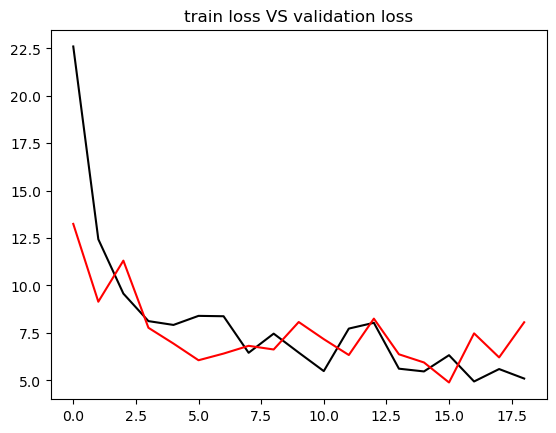

In [26]:
plt.plot(h['loss'], c='black')
plt.plot(h['val_loss'], c='red')
plt.title("train loss VS validation loss")
plt.show()

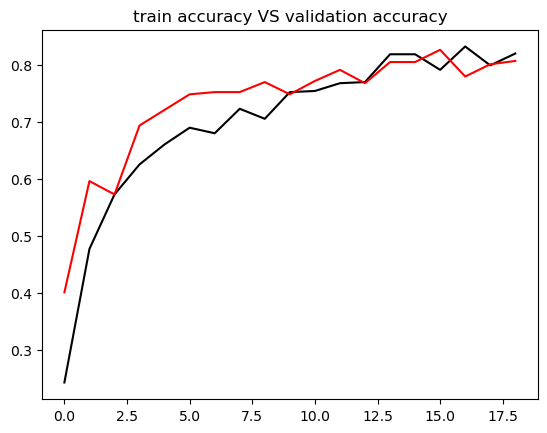

In [27]:
plt.plot(h['accuracy'], c='black')
plt.plot(h['val_accuracy'], c='red')
plt.title("train accuracy VS validation accuracy")
plt.show()

In [8]:
## Loading the Best Model
from keras.models import load_model

loaded_model = load_model("/Users/karthiksagar/anaconda3/CropDiseasePrediction/best_model.h5")


In [29]:
accuracy = loaded_model.evaluate_generator(test_set)[1]

/var/folders/vz/r8m2cmcn1vd2j0q6knf41nqw0000gp/T/ipykernel_54437/2653909727.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy = loaded_model.evaluate_generator(test_set)[1]


In [30]:
print(f"accuracy of validation data is : {round(100*accuracy, 2)} %")

accuracy of validation data is : 82.21 %


In [9]:
reference = dict(zip(list(training_set.class_indices.values()), list(training_set.class_indices.keys()))) 

In [11]:
reference

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Cherry_(including_sour)___Powdery_mildew',
 5: 'Cherry_(including_sour)___healthy',
 6: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 7: 'Corn_(maize)___Common_rust_',
 8: 'Corn_(maize)___Northern_Leaf_Blight',
 9: 'Corn_(maize)___healthy',
 10: 'Grape___Black_rot',
 11: 'Grape___Esca_(Black_Measles)',
 12: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 13: 'Grape___healthy',
 14: 'Orange___Haunglongbing_(Citrus_greening)',
 15: 'Peach___Bacterial_spot',
 16: 'Peach___healthy',
 17: 'Pepper,_bell___Bacterial_spot',
 18: 'Pepper,_bell___healthy',
 19: 'Potato___Early_blight',
 20: 'Potato___Late_blight',
 21: 'Potato___healthy',
 22: 'Squash___Powdery_mildew',
 23: 'Strawberry___Leaf_scorch',
 24: 'Strawberry___healthy',
 25: 'Tomato___Bacterial_spot',
 26: 'Tomato___Early_blight',
 27: 'Tomato___Late_blight',
 28: 'Tomato___Leaf_Mold',
 29: 'Tomato___Septoria_leaf_spo

In [6]:
def prediction(path):
    img = load_img(path, target_size=(256,256))
    i = img_to_array(img)
    im = preprocess_input(i)
    img = np.expand_dims(im, axis=0)
    pred = np.argmax(loaded_model.predict(img))
    if (reference[pred] == "Apple___Apple_scab"):
        reference[pred] = "Crop: Apple, Disease: Apple Scab, About Disease: Apple scab is a common disease of plants in the rose family that is caused by the ascomycete fungus Venturia inaequalis."
    if (reference[pred] == "Apple___Black_rot"):
        reference[pred] = "Crop: Apple, Disease: Black Rot, About Disease: Black rot is a fungal disease, caused by Diplodia seriata on apple. This disease can cause defoliation, fruit rot, and limb cankers. Leaf symptoms start appearing about one to three weeks after petal fall. Initially, the infections start as tiny purple spots., Cure: Apply fungicides and maintain good orchard hygiene."
    if (reference[pred] == "Apple___healthy"):
        reference[pred] = "Crop: Apple, Disease: Healthy, About Disease: No Disease Found."
    if (reference[pred] == "Apple___Cedar_apple_rust"):
        reference[pred] = "Crop: Apple, Disease: Cedar Apple Rust, About Disease: Large infestations of this rust can reduce yield on apples, blemish the fruit, and lead to weakening and death of redcedar. This particular rust produces four kinds of spores: basidiospores, teliospores, spermatia, and aeciospores."
    if (reference[pred] == "Cherry_(including_sour)___healthy"):
        reference[pred] = "Crop: Cherry, Disease: Healhty, About Disease: No Disease Found."
    if (reference[pred] == "Cherry_(including_sour)___Powdery_mildew"):
        reference[pred] = "Crop: Cherry, Disease: Powdery mildew, About Disease: Powdery mildew of sweet and sour cherry is caused by Podosphaera clandestina, an obligate biotrophic fungus. Mid- and late-season sweet cherry (Prunus avium) cultivars are commonly affected, rendering them unmarketable due to the covering of white fungal growth on the cherry surface."
    if (reference[pred] == "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot"):
        reference[pred] = "Crop: Corn (Maize), Disease: Cercospora leaf spot or Gray leaf spot, About Disease: Grey Leaf Spot is caused by a fungal pathogen (Pyricularia grisea) that readily infects and kills leaf blades. Leaf infections can progress into the crown area, resulting in death of individual plants. Moderate outbreaks of gray leaf spot result in clusters of thin, off-colored turf."
    if (reference[pred] == "Corn_(maize)___Northern_Leaf_Blight"):
        reference[pred] = "Crop: Corn (Maize), Disease: Northern Leaf Blight, About Disease: Northern corn leaf blight is caused by the fungus Setosphaeria turcica. Symptoms usually appear first on the lower leaves."
    if (reference[pred] == 'Corn_(maize)___Common_rust_'):
        reference[pred] = f"Crop: Corn (Maize), Disease: Common Rust on Crop, About Disease: Common rust produces rust-colored to dark brown, elongated pustules on both leaf surfaces. The pustules contain rust spores that are cinnamon brown in color. Pustules darken as they age."
    if (reference[pred] == 'Corn_(maize)___healthy'):
        reference[pred] = f"Crop: Corn (Maize), Disease: Healthy, About Disease: No Disease"
    if (reference[pred] == 'Grape___Black_rot'):
        reference[pred] = f"Crop: Grape, Disease: Black Rot, About Disease: Grape black rot is a fungal disease caused by an ascomycetous fungus, Guignardia bidwellii, that attacks grape vines during hot and humid weather."
    if (reference[pred] == 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'):
        reference[pred] = f"Crop: Grape, Disease: Leaf blight (Isariopsis Leaf Spot), About Disease: Initially lesions are dull red to brown in color turn black later. If disease is severe this lesions may coalesce. On berries we can see symptom similar to black rot but the entire clusters will collapse."
    if (reference[pred] == 'Grape___Esca_(Black_Measles)'):
        reference[pred] = f"Crop: Grape, Disease: Esca (Black Measles), About Disease: One of the common fungal diseases is Esca (Black Measles) which is found in the Grape Plants and can be easily identified as brown streaking lesions on any part of the leaf. The affected leaves can dry off completely and fall off from the plant prematurely which eventually results in death of the plant."
    if (reference[pred] == 'Grape___healthy'):
        reference[pred] = f"Crop: Grape, Disease: Healthy, About Disease: No Disease"
    if (reference[pred] == 'Orange___Haunglongbing_(Citrus_greening)'):
        reference[pred] = f"Crop: Orange, Disease: Haunglongbing (Citrus greening), About Disease: Huanglongbing is a bacterial disease that attacks the vascular system of plants. Once infected, there is no cure for the disease, and in areas where the disease is endemic, citrus trees decline and die within a few years."
    if (reference[pred] == 'Peach___Bacterial_spot'):
        reference[pred] = f"Crop: Peach, Disease: Bacterial Spot, About Disease: Peach scab, caused by the fungus Cladosporium carpophilum, is most often a problem in warm, wet weather following shuck-split and is also known as ink spot. Although the fungus infects leaves and twigs, disease symptoms are most often observed on the fruit."
    if (reference[pred] == 'Peach___healthy'):
        reference[pred] = f"Crop: Peach, Disease: Healthy, About Disease: No Disease."
    if (reference[pred] == 'Pepper,_bell___Bacterial_spot'):
        reference[pred] = f"Crop: Pepper, Disease: bell Bacterial spot, About Disease: The bacterium is carried within seed, or in solanaceous weeds and crop debris. Tomatoes are also susceptible. Disease development is favored by high nighttime temperatures and high moisture and may be arrested during prolonged dry spells."
    if (reference[pred] == 'Pepper,_bell___healthy'):
        reference[pred] = f"Crop: Pepper, Disease: Healthy, About Disease: No Disease."
    if (reference[pred] == 'Potato___Early_blight'):
        reference[pred] = f"Crop: Potato, Disease: Early Blight, About Disease: Early blight of potato is caused by the fungus, Alternaria solani, which can cause disease in potato, tomato, other members of the potato family, and some mustards. This disease, also known as target spot, rarely affects young, vigorously growing plants."
    if (reference[pred] == 'Potato___Late_blight'):
        reference[pred] = f"Crop: Potato, Disease: Late Blight, About Disease: Late blight is caused by the fungal-like oomycete pathogen Phytophthora infestans."
    if (reference[pred] == 'Potato___healthy'):
        reference[pred] = f"Crop: Potato, Disease: Healthy, About Disease: No Disease."
    if (reference[pred] == 'Squash___Powdery_mildew'):
        reference[pred] = f"Crop: Squash, Disease: Powdery Mildew, About Disease: Powdery mildew symptoms appear on leaves as white, powdery, circular to irregularly shaped patches. Mildew lesions are apparent on both sides of leaves as dusty, grayish brown deposits."
    if (reference[pred] == 'Strawberry___Leaf_scorch'):
        reference[pred] = f"Crop: Strawberry, Disease: Leaf Scorch, About Disease: Leaf scorch is caused by the fungus Diplocarpon earliana. Symptoms can be mistaken for common leaf spot, caused by M. fragariae."
    if (reference[pred] == 'Strawberry___healthy'):
        reference[pred] = f"Crop: Strawberry, Disease: Healthy, About Disease: No Disease."
    if (reference[pred] == 'Tomato___Bacterial_spot'):
        reference[pred] = f"Crop: Tomato, Disease: Bacterial Spot, About Disease: The disease affects all above ground parts of a tomato plant, including leaves, stems, and fruit. In rainy and wet weather conditions, the disease can cause early defoliation and fruit spotting, which results in reduced yield and non-marketable fruit., Cure: Use copper-based fungicides and practice crop rotation."
    if (reference[pred] == 'Tomato___healthy'):
        reference[pred] = f"Crop: Tomato, Disease: Healthy, About Disease: No Disease."
    if (reference[pred] == 'Tomato___Late_blight'):
        reference[pred] = f"Crop: Tomato, Disease: Late Blight, About Disease: Late blight is a potentially serious disease of potato and tomato and is caused by the water mold pathogen Phytophthora infestans. Late blight is especially damaging during cool, wet weather."
    if (reference[pred] == 'Tomato___Early_blight'):
        reference[pred] = f"Crop: Tomato, Disease: Early Blight, About Disease: Early blight, caused by Alternaria solani, is a common fungal disease of tomatoes grown in fields, greenhouses, and high tunnels. In warm, rainy and wet weather, epidemics of this disease can cause severe defoliation, yield loss, and poor fruit quality. The fungus also infects potato."
    if (reference[pred] == 'Tomato___Leaf_Mold'):
        reference[pred] = f"Crop: Tomato, Disease: Leaf Mold, About Disease: Tomato leaf mold is caused by a fungal pathogen called Passalora fulva (syn. Cladosporium fulvum). It is an ascomycete fungus that lives on living tomato leaves. The fungus produces conidia that infect the lower surfaces of leaves."
    if (reference[pred] == 'Tomato___Septoria_leaf_spot'):
        reference[pred] = f"Crop: Tomato, Disease: Septoria Leaf Spot, About Disease: Septoria leaf spot is caused by the fungus Septoria lycopersici. This fungus can attack tomatoes at any stage of development, but symptoms usually first appear on the older, lower leaves and stems when plants are setting fruit."
    if (reference[pred] == 'Tomato___Spider_mites Two-spotted_spider_mite'):
        reference[pred] = f"Crop: Tomato, Disease: Spider Mites, About Disease: Tomato red spider mite feeding causes whitening or yellowing of leaves, which then dry out and eventually fall off. In the case of severe attacks, plant damage progresses very quickly, and hosts may die within 3-5 weeks, if no management actions are taken."
    if (reference[pred] == 'Tomato___Target_Spot'):
        reference[pred] = f"Crop: Tomato, Disease: Target Spot, About Disease: Target spot of tomato is caused by the fungal pathogen Corynespora cassiicola. 1 The disease occurs on field-grown tomatoes in tropical and subtropical regions of the world."
    if (reference[pred] == 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'):
        reference[pred] = f"Crop: Tomato, Disease: Yellow Leaf Curl Virus, About Disease: Tomato yellow leaf curl virus is a DNA virus from the genus Begomovirus and the family Geminiviridae. TYLCV causes the most destructive disease of tomato, and it can be found in tropical and subtropical regions causing severe economic losses."
    if (reference[pred] == 'Tomato___Tomato_mosaic_virus'):
        reference[pred] = f"Crop: Tomato, Disease: Mosaic Virus, About Disease: The mosaic virus is a parasite that destroys plants, gardens, and crops down to their molecular level. Once a plant contracts the mosaic virus, the infected plant can then spread the virus to other plants and even affect an entire harvest if left untreated."
    
    
    print(f"{reference[pred]}")

In [ ]:
prediction(path="/Users/karthiksagar/anaconda3/CropDiseasePrediction/CropDataset/train/Grape___Esca_(Black_Measles)/0b351ad3-5a0c-4a62-b803-9f17fed7d3ea___FAM_B.Msls 1106.JPG")